<h1><center>Titanic - Machine Learning from Disaster</center></h1>

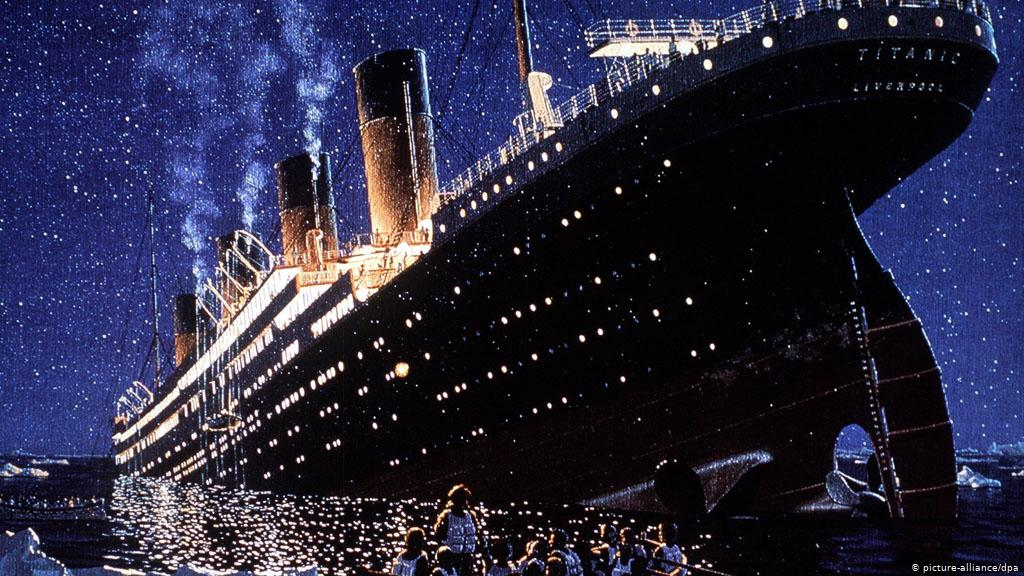

<h2><center> Exploratory Data Analysis</center></h2>

In [ ]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
from math import *
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import iplot
import plotly.graph_objects as go
from collections import Counter
# from ipywidgets import widgets
from ipywidgets import *
import missingno as msno

In [ ]:
train_df=pd.read_csv('../input/titanic/train.csv')
test_df=pd.read_csv('../input/titanic/test.csv')
sub_df=pd.read_csv('../input/titanic/gender_submission.csv')
IDtest = test_df["PassengerId"]

In [ ]:
train_df.head()

<h3>Data Description</h3>

In [ ]:
train_df.info()

#### Columns Description

- PassengerId: Passenger ID number
- Survived: Passegner survived or not (0= Not survived, 1=Survived)
- pclass: A proxy for socio-economic status (1st = Upper, 2nd = Middle, 3rd = Lower)
- age: Passenger Age
- sibsp:  siblings / spouses aboard the Titani
- parch:  of parents / children aboard the Titanic
- fare:	Passenger fare
- sex :	male/female
- Embarked : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

<h4> Outlier Detection</h4>

In [ ]:
def detect_outliers(df,n,features):
    outlier_indices = []
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])

In [ ]:
# Drop outliers
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
## Join train and test datasets 
train_len = len(train_df)
titanic_data =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)

In [ ]:
# Fill empty and NaNs values with NaN
titanic_data = titanic_data.fillna(np.nan)
# Check for Null values
titanic_data.isnull().sum()

<h4> First, find the Correlation</h4>

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
c = sns.heatmap(titanic_data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

#### 
Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features

<h4>Survived Column Analysis</h4>

In [ ]:
values=titanic_data["Survived"].value_counts().values
fig = go.Figure(data=[go.Pie(title='Titanic Survived/Not Survived Data',labels=['Not Survived','Survived'], values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

In [ ]:
sns.factorplot('Survived',data=titanic_data,hue='Sex',kind='count')

<h5> From above plots we can analyze that more male died and more female survived.</h5>

<h4> Let's Explore more 'Columns' quickly!!! </h4>

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=5,figsize=(15,20))

titanic_data['Sex'].value_counts().plot.pie(ax=ax[0,0])
sns.countplot(x='Sex', hue="Survived", data=titanic_data,ax=ax[0,1])

titanic_data['Embarked'].value_counts().plot.pie(ax=ax[1,0])
sns.countplot(x='Embarked', hue="Survived", data=titanic_data,ax=ax[1,1])

titanic_data['Pclass'].value_counts().plot.pie(ax=ax[2,0])
sns.countplot(x='Pclass', hue="Survived", data=titanic_data,ax=ax[2,1])

titanic_data['SibSp'].value_counts().plot.pie(ax=ax[3,0])
sns.countplot(x='SibSp', hue="Survived", data=titanic_data,ax=ax[3,1])

titanic_data['Parch'].value_counts().plot.pie(ax=ax[4,0])
sns.countplot(x='Parch', hue="Survived", data=titanic_data,ax=ax[4,1])

plt.legend()

#### Inference

##### 1. Sex
It is clearly obvious that Male have less chance to survive than Female.So Sex, might play an important role in the prediction of the survival.
##### 2. Pclass
The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.
##### 3. Embarked
It seems that passenger coming from Cherbourg (C) have more chance to survive. My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S)
##### 4. SibSp 
It seems that passengers having a lot of siblings/spouses have less chance to survive.
Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive
##### 5. Parch
Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

<h4>Missing Values</h4>

In [ ]:
msno.bar(titanic_data)

##### Inference
As we see, Age column contains 256 missing values in the whole dataset. Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

In [ ]:
# Explore Fare distribution 
g = sns.distplot(train_df["Fare"], color="m", label="Skewness : %.2f"%(titanic_data["Fare"].skew()))
g = g.legend(loc="best")

##### Inference
As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled. In this case, it is better to transform it with the log function to reduce this skew.

<h3>Feature Engineering</h3>

##### Fare

In [ ]:
# Apply log to Fare to reduce skewness distribution
titanic_data["Fare"] = train_df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.distplot(train_df["Fare"], color="b", label="Skewness : %.2f"%(titanic_data["Fare"].skew()))
g = g.legend(loc="best")

##### Embarked

In [ ]:
# Embarked has 2 missing values
#Fill Embarked nan values of dataset set with 'S' most frequent value
titanic_data["Embarked"] = titanic_data["Embarked"].fillna("S")

##### Fare

In [ ]:
#Fill Fare missing values with the median value
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].median())

##### Sex

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
titanic_data["Sex"] = titanic_data["Sex"].map({"male": 0, "female":1})

##### Age

In [ ]:
# Filling missing value of Age 
## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(titanic_data["Age"][titanic_data["Age"].isnull()].index)
for i in index_NaN_age :
    age_med = titanic_data["Age"].median()
    age_pred = titanic_data["Age"][((titanic_data['SibSp'] == titanic_data.iloc[i]["SibSp"]) & (titanic_data['Parch'] == titanic_data.iloc[i]["Parch"]) & (titanic_data['Pclass'] == titanic_data.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        titanic_data['Age'].iloc[i] = age_pred
    else :
        titanic_data['Age'].iloc[i] = age_med

##### Name

In [ ]:
# Get Title from Name
titanic_data_title = [i.split(",")[1].split(".")[0].strip() for i in titanic_data["Name"]]
titanic_data["Title"] = pd.Series(titanic_data_title)
# train_df["Title"].head()
titanic_data["Title"].unique()

In [ ]:
# Convert to categorical values Title 
titanic_data["Title"] = titanic_data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_data["Title"] = titanic_data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
titanic_data["Title"] = titanic_data["Title"].astype(int)

In [ ]:
# Drop Name variable
titanic_data.drop(labels = ["Name"], axis = 1, inplace = True)

##### Family

In [ ]:
# Create a family size descriptor from SibSp and Parch
titanic_data['Family_Size']=titanic_data["SibSp"] + titanic_data["Parch"] + 1

In [ ]:
#The family size seems to play an important role, survival probability is worst for large families.
#Additionally, i decided to created 4 categories of family size.
titanic_data['Single'] = titanic_data['Family_Size'].map(lambda s: 1 if s == 1 else 0)
titanic_data['SmallF'] = titanic_data['Family_Size'].map(lambda s: 1 if  s == 2  else 0)
titanic_data['MedF'] = titanic_data['Family_Size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
titanic_data['LargeF'] = titanic_data['Family_Size'].map(lambda s: 1 if s >= 5 else 0)

In [ ]:
titanic_data.head()

In [ ]:
titanic_data.info()

In [ ]:
# convert to indicator values Title and Embarked 
titanic_data = pd.get_dummies(titanic_data, columns = ["Title"])
titanic_data = pd.get_dummies(titanic_data, columns = ["Embarked"], prefix="Em")

In [ ]:
titanic_data.head()

<b> We have 22 features now.....</b>

##### Cabin

The Cabin feature column contains 292 values and 1007 missing values. Let's assume that passengers without a cabin have a missing value displayed instead of the cabin number.

In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
titanic_data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in titanic_data['Cabin'] ])
titanic_data = pd.get_dummies(titanic_data, columns = ["Cabin"],prefix="Cabin")

##### Ticket

For more information about the passengers let's replace the Ticket feature column by the ticket prefix. 

In [ ]:
#extract the ticket prefix. When there is no prefix it returns X. 
Ticket = []
for i in list(titanic_data.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
titanic_data["Ticket"] = Ticket
titanic_data = pd.get_dummies(titanic_data, columns = ["Ticket"], prefix="T")

##### Pclass

In [ ]:
# Create categorical values for Pclass
titanic_data["Pclass"] = titanic_data["Pclass"].astype("category")
titanic_data = pd.get_dummies(titanic_data, columns = ["Pclass"],prefix="Pc")

##### PassengerId

In [ ]:
# Drop useless variables 
titanic_data.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
titanic_data.head()

<h2><center>Modelling</center></h2>

In [ ]:
# Transform dataset back to train and test dataset
train_df = titanic_data[:train_len]
test_df = titanic_data[train_len:]
test_df.drop(labels=["Survived"],axis = 1,inplace=True)

In [ ]:
# Separate train features and label 
train_df["Survived"] = train_df["Survived"].astype(int)
Y_train = train_df["Survived"]
X_train = train_df.drop(labels = ["Survived"],axis = 1)

### Let's compare 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.
<ol>
  <li>Logistic regression</li>
  <li>SVC</li>
  <li>KNN</li>
  <li>Decision Tree</li>
  <li>Random Forest</li>
  <li>Gradient Boosting</li>
  <li>AdaBoost</li>
  <li>Extra Trees</li>
  <li>Multiple layer perceprton (neural network)</li>
  <li>Linear Discriminant Analysis</li>
</ol>

In [ ]:
# Libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [ ]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=10)

In [ ]:
# Test all the above stated algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
# I chose the SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

##### Inference
GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

#### Ensemble modeling
##### Combining models
Let's use voting classifier to combine the predictions coming from the 5 classifiers. I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
# Predict and Submit results
test_Survived = pd.Series(votingC.predict(test_df), name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv("ensemble_python_voting.csv",index=False)